## DASC 550 Project2: House Price Prediction
### Burak Albayrak
### 0078324

#### Submission Deadline: August 22, 2022 11:59 PM

In this project, you are going to build an end-to-end machine learning solution using a convolutional neural network for house price prediction problem. You should use `tensorflow` library to build your neural network.

The data set is provided in a file called `HD.zip`, which contains 4 images per house and `HousesInfo.txt`. You will predict the price  of each house (given in the last column of `HousesInfo.txt`) using the images provided.

While building your regression model, you should use the randomly selected 80\% as training set and the remaining 20\% as test set. You should report the predictive performances on learning, validation and test sets.

You should also report the metrics you choose to measure the performance of the solution you developed and the reasoning behind your choices.

##### Selecting Features

* Since our data has numeric columns with different ranges, scaled all columns with the min max scaling. While doing this I was careful to do fitting and transforming on training data and this transformation applied to test data 
* Target column has a big scale of house prices so that I scaled this column also

##### Metrics and Evaluating Model

* I constructed CNN model with filters, maxpooling and dropout layers
* Since our problem is regression, I put linear activation to output node
* I used early stopping, with patience 5 and monitored validation loss 
* For metrics I only used mse for this model
*                 Training mse: 0.0047  
*                 Validation mse: 0.0041 
*                 Test mse: 0.0094 

##### Conclusion
* After model prediction, I realized that houses with bright pictures has higher error in prediction. As we look at the pictures of 14th house, since distinguishable coloring, empirically its price more accurate

In [42]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tensorflow.keras.preprocessing import image
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.layers import Dense
from sklearn import datasets
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import time

In [43]:
def load_house_images(data_path, house_count, image_size):
    house_images = np.zeros((house_count, 2 * image_size[0], 2 * image_size[1], 3),
                             dtype = "uint8")
    for i in range(house_count):
        bathroom = image.load_img("./{}/{}_bathroom.jpg".format(data_path, i + 1),
                                  target_size = image_size)
        house_images[i, 0:image_size[0], 0:image_size[1], :] = bathroom
        bedroom = image.load_img("./{}/{}_bedroom.jpg".format(data_path, i + 1),
                                 target_size = image_size)
        house_images[i, 0:image_size[0], image_size[1]:(2 * image_size[1]), :] = bedroom
        frontal = image.load_img("./{}/{}_frontal.jpg".format(data_path, i + 1),
                                  target_size = image_size)
        house_images[i, image_size[0]:(2 * image_size[0]), 0:image_size[1], :] = frontal
        kitchen = image.load_img("./{}/{}_kitchen.jpg".format(data_path, i + 1),
                                 target_size = image_size)
        house_images[i, image_size[0]:(2 * image_size[0]), image_size[1]:(2 * image_size[1]), :] = kitchen
    return house_images

def load_house_prices(data_path):
    houses_info = np.loadtxt("./{}/HousesInfo.txt".format(data_path))
    return houses_info[:, 4]

In [44]:
house_images = load_house_images("HD", 535, (128, 128))
print(house_images.shape)

(535, 256, 256, 3)


In [45]:
house_prices = load_house_prices("HD")
print(house_prices.shape)

(535,)


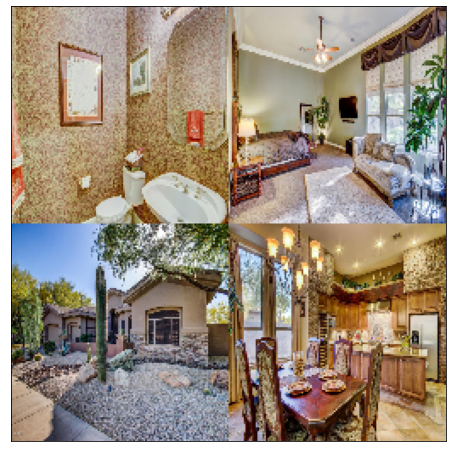

869500.0


In [46]:
#display the first house's picture 
plt.figure(figsize = (8, 8))
plt.imshow(house_images[0, :, :, :])
plt.xticks([])
plt.yticks([])
plt.show()
#display the first house's price 
print(house_prices[0])

In [47]:
X = house_images
y = house_prices

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123)

In [49]:
X_train.shape

(428, 256, 256, 3)

In [51]:
X_train = X_train / 255.0
X_test = X_test / 255.0
maxPrice = y_train.max()
y_train = y_train / maxPrice
y_test = y_test / maxPrice
print(X_train.shape)
print(X_test.shape)

(428, 256, 256, 3)
(107, 256, 256, 3)


In [52]:
X_train[0]

array([[[0.46666667, 0.36078431, 0.14509804],
        [0.14901961, 0.0627451 , 0.        ],
        [0.2       , 0.09411765, 0.01960784],
        ...,
        [0.73333333, 0.54117647, 0.38431373],
        [0.71764706, 0.5254902 , 0.36470588],
        [0.65882353, 0.46666667, 0.29803922]],

       [[0.44705882, 0.31372549, 0.17647059],
        [0.25098039, 0.14117647, 0.05490196],
        [0.21960784, 0.12941176, 0.00392157],
        ...,
        [0.75294118, 0.56078431, 0.40392157],
        [0.71764706, 0.5254902 , 0.36470588],
        [0.6627451 , 0.47058824, 0.30196078]],

       [[0.44705882, 0.30196078, 0.09803922],
        [0.24313725, 0.10588235, 0.        ],
        [0.22745098, 0.10588235, 0.        ],
        ...,
        [0.77254902, 0.56862745, 0.41176471],
        [0.70588235, 0.50588235, 0.3372549 ],
        [0.69411765, 0.49411765, 0.31764706]],

       ...,

       [[0.46666667, 0.40392157, 0.35294118],
        [0.38823529, 0.30196078, 0.25882353],
        [0.54509804, 0

In [53]:
y_train[0]

0.10908159781495391

In [65]:
Xlearn, Xvalidation, ylearn, yvalidation = train_test_split(X_train, y_train, test_size = 0.25,
                                                            random_state = 1234, shuffle = True)
print(Xlearn.shape, ylearn.shape, Xvalidation.shape, yvalidation.shape)

(321, 256, 256, 3) (321,) (107, 256, 256, 3) (107,)


In [83]:
CNN_model = keras.models.Sequential([
    keras.layers.Input(shape = (X_train.shape[1], 
                                X_train.shape[2],
                                X_train.shape[3])),
    keras.layers.Conv2D(filters = 8, kernel_size = (3, 3),
                        strides = 1),
    keras.layers.Conv2D(filters = 8, kernel_size = (3, 3),
                        strides = 1, ),
    keras.layers.Activation("relu"),
    keras.layers.Dropout(0.5),
    keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2),
    keras.layers.Conv2D(filters = 8, kernel_size = (2, 2), 
                        strides = 1),
    keras.layers.Conv2D(filters = 8, kernel_size = (2, 2), 
                        strides = 1),
    keras.layers.Activation("relu"),
    keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation = "relu"),
    keras.layers.Dense(1, activation = "linear", kernel_regularizer = keras.regularizers.l2(l2 = 0.1))
])
# CNN_model.summary()
# keras.utils.plot_model(CNN_model, show_shapes = True)

In [84]:
# compiled network
CNN_model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
                #   loss=tf.keras.losses.MeanSquaredError(),
                  loss = "mean_squared_error",
                  metrics = ["mse"])

In [85]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)   

In [86]:
# learned network
start_time = time.time()
cnn_history = CNN_model.fit(X_train, y_train, epochs = 20, callbacks=[monitor],
                            validation_data = (Xvalidation, yvalidation),
                            batch_size = 32,
                            verbose = 1, 
                            )
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Epoch 1/20
14/14 [==============================] - 9s 573ms/step - loss: 3.6444 - mse: 3.4473 - val_loss: 0.2878 - val_mse: 0.0931
Epoch 2/20
14/14 [==============================] - 8s 552ms/step - loss: 0.2542 - mse: 0.0610 - val_loss: 0.1979 - val_mse: 0.0065
Epoch 3/20
14/14 [==============================] - 8s 544ms/step - loss: 0.2042 - mse: 0.0141 - val_loss: 0.1937 - val_mse: 0.0053
Epoch 4/20
14/14 [==============================] - 8s 539ms/step - loss: 0.1958 - mse: 0.0087 - val_loss: 0.1916 - val_mse: 0.0061
Epoch 5/20
14/14 [==============================] - 8s 540ms/step - loss: 0.1913 - mse: 0.0071 - val_loss: 0.1899 - val_mse: 0.0073
Epoch 6/20
14/14 [==============================] - 8s 543ms/step - loss: 0.1882 - mse: 0.0068 - val_loss: 0.1873 - val_mse: 0.0075
Epoch 7/20
14/14 [==============================] - 8s 539ms/step - loss: 0.1852 - mse: 0.0066 - val_loss: 0.1833 - val_mse: 0.0063
Epoch 8/20
14/14 [==============================] - 8s 541ms/step - loss: 0.

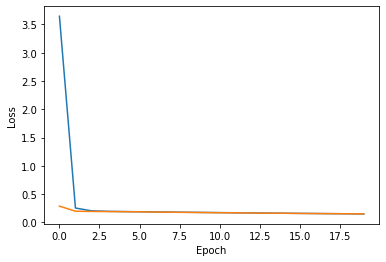

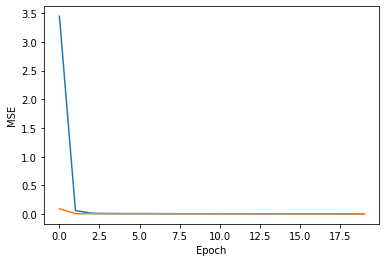

In [87]:
plt.plot(cnn_history.history["loss"])
plt.plot(cnn_history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.plot(cnn_history.history["mse"])
plt.plot(cnn_history.history["val_mse"])
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

In [89]:
ytrain_hat = CNN_model.predict(X_train)
print(mean_squared_error(y_train, ytrain_hat))
ytest_hat = CNN_model.predict(X_test)
print(mean_squared_error(y_test, ytest_hat))

In [90]:
print(CNN_model.evaluate(X_train, y_train))
print(CNN_model.evaluate(Xvalidation, yvalidation))
print(CNN_model.evaluate(X_test, y_test))

14/14 [==============================] - 1s 87ms/step - loss: 0.1513 - mse: 0.0047
[0.15129806101322174, 0.00469916732981801]
4/4 [==============================] - 0s 72ms/step - loss: 0.1507 - mse: 0.0041
[0.15072470903396606, 0.004125826060771942]
4/4 [==============================] - 0s 75ms/step - loss: 0.1560 - mse: 0.0094
[0.1559598296880722, 0.00936094205826521]


In [96]:
print(y_test[14]*maxPrice)
print(ytest_hat[14]*maxPrice)

250000.0
[256779.53]


In [76]:
y_train.shape

(428,)

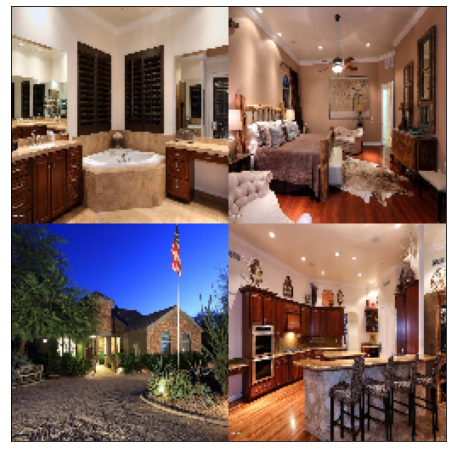

700000.0


In [101]:
#display the first house's picture 
plt.figure(figsize = (8, 8))
plt.imshow(house_images[14, :, :, :])
plt.xticks([])
plt.yticks([])
plt.show()
#display the first house's price 
print(house_prices[14])